# Preprocess

In [2]:
import h5py
import os
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import random

root_URL = r'/Users/wangyutao/Desktop/1901213567_王宇涛_作业3/'
train_URL = root_URL + r'Data/train/digitStruct.mat'
test_URL = root_URL + r'Data/test/digitStruct.mat'

In [ ]:
# 查看文件结构
file = h5py.File(train_URL,'r')
data = file['digitStruct']
name = data['name']
bbox = data['bbox']

print(name.shape)
print(bbox.shape)

In [ ]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inputFile):
        self.inputFile = h5py.File(inputFile, 'r')
        self.digitStructName = self.inputFile['digitStruct']['name']
        self.digitStructBbox = self.inputFile['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inputFile[self.digitStructName[n][0]]])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inputFile[attr[j].item()][0][0] for j in range(len(attr))]
        else:
            attr = [attr[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inputFile[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inputFile[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inputFile[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inputFile[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inputFile[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'Name' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['Bbox'] = figures
            result.append(item)
        return result

In [ ]:
# 格式转换
train = DigitStructFile(train_URL)
train_data = train.getAllDigitStructure_ByDigit()

test = DigitStructFile(test_URL)
test_data = test.getAllDigitStructure_ByDigit()

In [ ]:
# 查看元素
test_data[2019]

In [ ]:
# 存入 pickle
pickle_file = 'svhn_raw.pkl'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_data': train_data,
    'test_data': test_data,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [2]:
# 读入 pkl
pickle_file = 'svhn_raw.pkl'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data = save['train_data']
    test_data = save['test_data']
    del save
    print('Train set', len(train_data))
    print('Test set', len(test_data))

Train set 33402
Test set 13068


In [14]:
width_size = 112
height_size = 56

class Dataset:
    """crop images and save them to numpy ndarray"""
    
    def __init__(self, digitStruct, folder):
        self.digitStruct = digitStruct
        self.folder = folder
        
    def setDataset(self):
        self.images = np.ndarray(shape=(len(self.digitStruct), height_size, width_size), dtype='float32')
        
        # 1 length + 5 labels, 0 represents none
        self.labels = np.ones(shape=(len(self.digitStruct), 6), dtype='int') * 10 
        self.bboxes = np.zeros(shape=(len(self.digitStruct), 4), dtype='float32')
        
    def getDataset(self):
        
        self.setDataset()
        
        for i in range(len(self.digitStruct)):
            
            fin = os.path.join(self.folder, self.digitStruct[i]['Name'])
            im = Image.open(fin)
            
            boxes = self.digitStruct[i]['Bbox']
            
            # images
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            
            box = self.img_box(im, left, top, height, width)

            size = (width_size, height_size)
            region = im.resize(size)
            region = self.normalization(region)
            self.images[i,:,:] = region[:,:]
            
            
            # labels
            if len(boxes) > 5:
                print(fin, "has more than 5 digits")
            else:
                self.labels[i,0] = len(boxes)
                self.labels[i,1:len(boxes)+1] = [int(j['label'] if j['label'] != 10 else 0) for j in boxes]
#                 print(self.labels[i,len(boxes)+1:])
#                 print(box)
                self.bboxes[i,:] = box
            
            
        print('images:',self.images.shape)
        print('labels:',self.labels.shape)
        print('bboxes:',self.bboxes.shape)
        return self.images, self.labels, self.bboxes
        
    def img_box(self, im, left, top, height, width):

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = min(im.size[1], im_top + im_height * 1.05)
        im_right = min(im.size[0], im_left + im_width * 1.05)
        
        im_top = im_top * height_size / im.size[1]
        im_bottom = im_bottom * height_size / im.size[1]
        im_left = im_left * width_size / im.size[0]
        im_right = im_right * width_size / im.size[0]

        return (im_left, im_top, im_right, im_bottom)


    def normalization(self, img):
#         im = self.rgb2gray(img) # RGB to greyscale
        im = img.convert('L')
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        return (im - mean) / std  
    
    def rgb2gray(self, img):
        return np.dot(np.array(img, dtype='float32'), [0.299, 0.587, 0.114])

In [15]:
train_dataset = Dataset(train_data, root_URL + 'Data/train')
train_images, train_labels, train_bboxes = train_dataset.getDataset()

/Users/wangyutao/Desktop/1901213567_王宇涛_作业3/Data/train/29930.png has more than 5 digits
images: (33402, 56, 112)
labels: (33402, 6)
bboxes: (33402, 4)


[ 2  1  9 10 10 10]
[35.874763 10.536    63.330635 48.      ]
12.663876 -16.41678


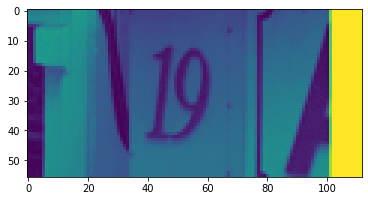

In [16]:
num = 0
plt.imshow(train_images[num,:,:])
print(train_labels[num])
print(train_bboxes[num])
print(np.max(train_images),np.min(train_images))

In [17]:
train_images = np.delete(train_images, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)
train_bboxes = np.delete(train_bboxes, 29929, axis=0)

print(train_images.shape)
print(train_labels.shape)
print(train_bboxes.shape)

(33401, 56, 112)
(33401, 6)
(33401, 4)


In [18]:
test_dataset = Dataset(test_data, root_URL + 'Data/test')
test_images, test_labels, test_bboxes = test_dataset.getDataset()

images: (13068, 56, 112)
labels: (13068, 6)
bboxes: (13068, 4)


In [19]:
def disp_sample_dataset(images, labels):
    items = random.sample(range(images.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(labels[i][1:5])
        plt.imshow(images[i,:,:])

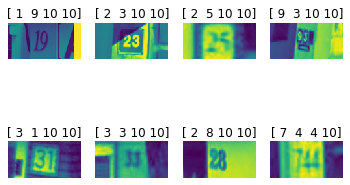

In [20]:
disp_sample_dataset(train_images, train_labels)

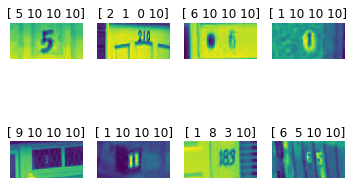

In [21]:
disp_sample_dataset(test_images, test_labels)

In [22]:
# 保存 dataset
pickle_file = 'svhn_dataset_112x56.pkl'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_images': train_images,
    'train_labels': train_labels,
    'train_bboxes': train_bboxes,
    'test_images': test_images,
    'test_labels': test_labels,
    'test_bboxes': test_bboxes,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done


In [3]:
pickle_file = 'svhn_dataset_112x56.pkl'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_images = save['train_images']
    train_labels = save['train_labels']
    train_bboxes = save['train_bboxes']
    test_images = save['test_images']
    test_labels = save['test_labels']
    test_bboxes = save['test_bboxes']
    del save  # hint to help gc free up memory
    print('Train set', train_images.shape, train_labels.shape, train_bboxes.shape)
    print('Test set', test_images.shape, test_labels.shape, test_bboxes.shape)

Train set (33401, 56, 112) (33401, 6) (33401, 4)
Test set (13068, 56, 112) (13068, 6) (13068, 4)


[ 2  1  7 10 10 10]
12.663876 -16.41678
1 5


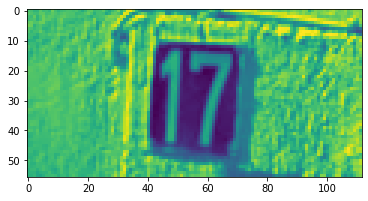

In [5]:
num = 424
plt.imshow(train_images[num,:,:])
print(train_labels[num])
# print(train_images[num,:,:])
print(np.max(train_images),np.min(train_images))
print(np.min(train_labels[:,0]),np.max(train_labels[:,0]))